In [1]:
"""""""""""""""""""""""""""""""""""""""""""""""""" 
# conda env create -f environment.yml
""""""""""""""""""""""""""""""""""""""""""""""""""
# !pip install -r requirements.txt
"""""""""""""""""""""""""""""""""""""""""""""""""" 

import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import pickle
import torch
from random import sample
from helper_functions import *
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline


<Figure size 640x480 with 0 Axes>

In [2]:
img_folder = "../demo-data" # Load images from a folder that you want to detect. 
weight_path = "../YoloPCB/training_results/PCB_detection_best.pt" # Use custom weights from fine tuning YOLO to PCBs
yolo_path = "../YoloPCB" # Downloaded YOLO model from Git. This can run offline. 

# Load images that you want to detect
image_list = [load_image(os.path.join(img_folder, img)) for img in os.listdir(img_folder)]
# Load object detection model (YOLOv5)
model = load_model(yolo_path, weight_path, confidence = 0.5)


YOLOv5 🚀 2023-4-20 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
Model summary: 322 layers, 86193601 parameters, 0 gradients
Adding AutoShape... 


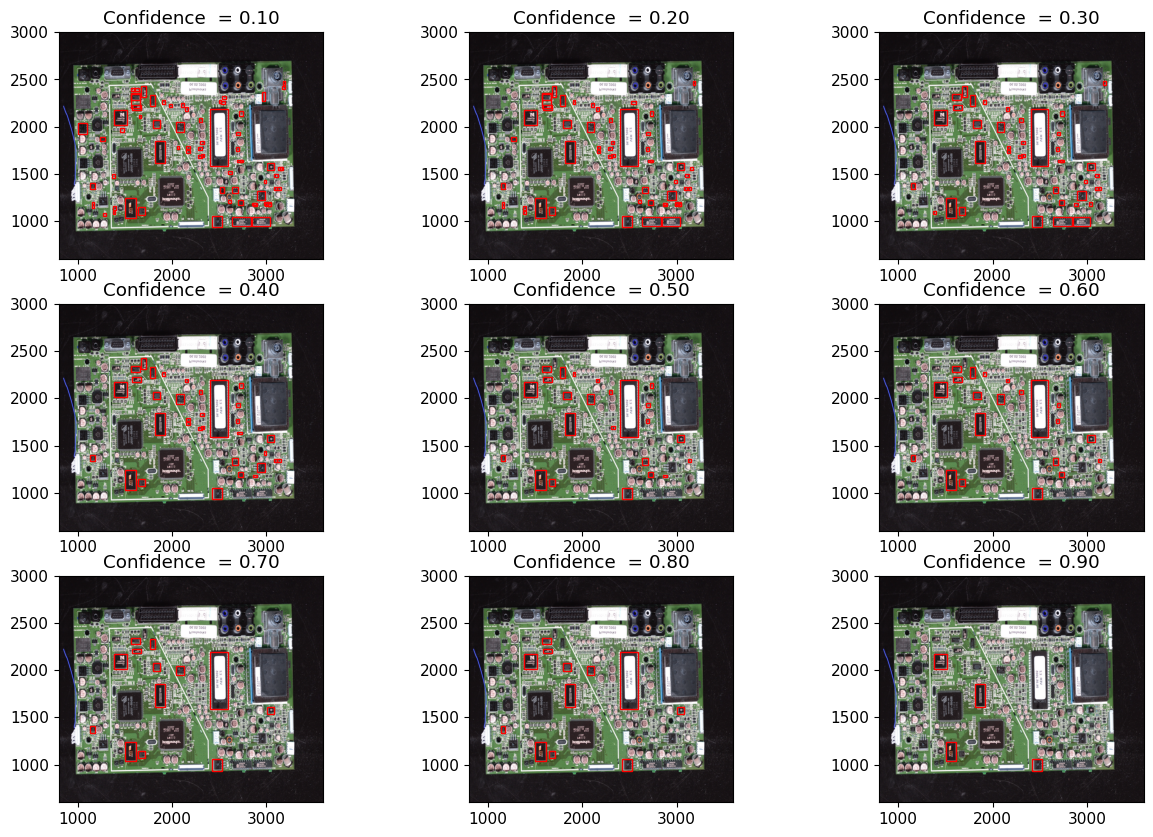

In [5]:
# Visualize different confidence levels from YOLO!
%matplotlib inline

image_array1 = image_list[2][1]
fig = plt.figure(figsize = (15, 10))

for idx, C in enumerate(np.arange(0.1, 1, 0.1)):
    model.conf = C
    # Inference
    results = model(image_array1) # batch of images
    # Results
    df  = pd.DataFrame(results.pandas().xyxy[0])
    df[['xmin', 'xmax','ymin', 'ymax']] = df[['xmin', 'xmax','ymin', 'ymax']].astype(int)
    # Plot results
    plot_conf(df, C, image_array1, fig, idx)
plt.show()

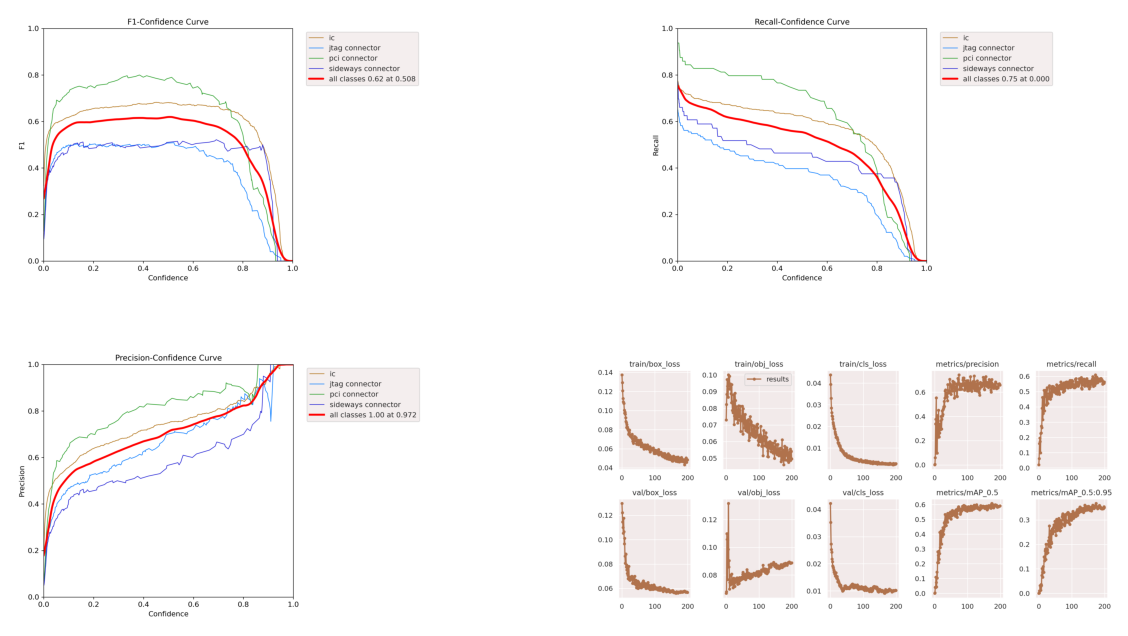

In [7]:
# load results from YOLO detection
path_to_imgages = '../YoloPCB/training_results/'

fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(cv2.imread(os.path.join(path_to_imgages, "F1_curve.png")))
ax.axis(False)
ax = fig.add_subplot(2, 2, 2)
ax.imshow(cv2.imread(os.path.join(path_to_imgages, "R_curve.png")))
ax.axis(False)
ax = fig.add_subplot(2, 2, 3)
ax.imshow(cv2.imread(os.path.join(path_to_imgages, "P_curve.png")))
ax.axis(False)
ax = fig.add_subplot(2, 2, 4)
ax.imshow(cv2.imread(os.path.join(path_to_imgages, "results.png")))
ax.axis(False)
plt.show()

In [8]:
model.conf = 0.75
ic_s = []
# Inference
for idx, (save_name, img_array1) in enumerate(image_list):
    results = model(img_array1) # batch of images
    # Results
    df  = pd.DataFrame(results.pandas().xyxy[0])
    df[['xmin', 'xmax','ymin', 'ymax']] = df[['xmin', 'xmax','ymin', 'ymax']].astype(int)
    for ixcx, i in df.iterrows():
        if i['name'] == 'ic':
                x, w = dict(i)['xmin'], dict(i)['xmax'] - dict(i)['xmin']
                y, h = dict(i)['ymin'], dict(i)['ymax'] - dict(i)['ymin']
                ic_s.append(cv2.resize(img_array1[dict(i)['ymin']:dict(i)['ymax'], dict(i)['xmin']:dict(i)['xmax']], (400, 400)))


In [9]:
# Anomaly detection models could be updated with additional data. 
savedata = False
if savedata:
    path_to_save = '/Users/ryan/Documents/PCB-Forensics/data/autoencoder-data/More_training_data'
    for idx, img in enumerate(ic_s):
        cv2.imwrite(os.path.join(path_to_save, str(idx) + 'IC_.jpg'), img)

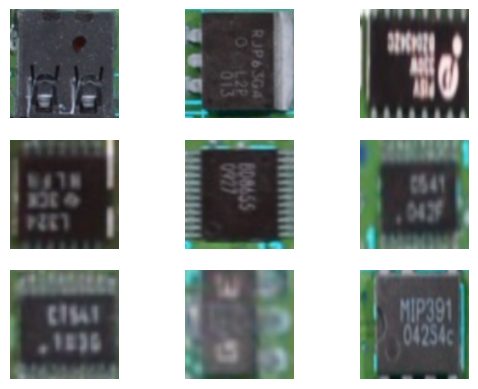

In [10]:
fig = plt.figure()
for idx, img in enumerate(sample(ic_s, 9)):    
    ax = fig.add_subplot(3,3, idx+1)
    plt.imshow(img/255)
    plt.axis('off')

plt.show()

In [11]:
# Load in the model
device = torch.device('cpu')
%run ../pyscripts/CNN_autoencoder.py
CNN_AE = torch.load('../models/IC_AE_cpu.pth')
CNN_AE.to(device)
CNN_AE.eval()


CNNAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2), padding=(6, 6))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2))
    (7): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1)
    (4): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(2, 2))
    (7): Sigmoid()
  )
)

<Figure size 640x480 with 0 Axes>

In [12]:
imgs = torch.Tensor((np.array(ic_s)/255).transpose(0, 3, 1, 2)).to(device)
output = CNN_AE(imgs[:6,:,:,:])

out_imgs = output.detach().cpu().numpy().transpose(0, 2, 3, 1)
in_imgs = imgs.detach().cpu().numpy().transpose(0, 2, 3, 1)

print('input shape')
print(*in_imgs.shape)
print("-"*50)
print('output shape')
print(*out_imgs.shape)

input shape
49 400 400 3
--------------------------------------------------
output shape
6 400 400 3


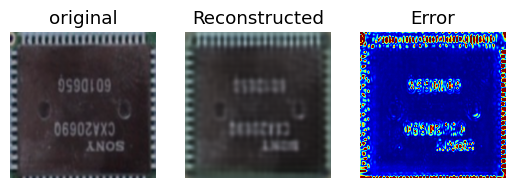

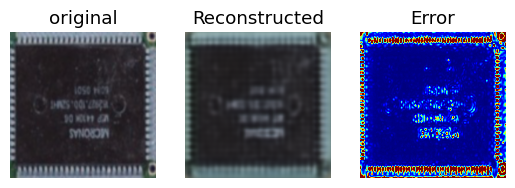

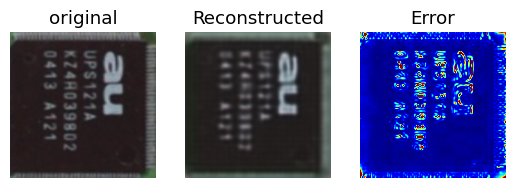

In [13]:
for i in range(3):
    plot_recon_mse(in_imgs[i,:,:,:],out_imgs[i,:,:,:])

In [14]:
imgs = torch.Tensor((np.array(ic_s)/255).transpose(0, 3, 1, 2)).to(device)
testloader = DataLoader(imgs, batch_size=1)
mse_all = []
for i in testloader:
    output = CNN_AE(i)

    out_imgs = output.detach().cpu().numpy().transpose(0, 2, 3, 1)
    in_imgs = imgs.detach().cpu().numpy().transpose(0, 2, 3, 1)

    mse_all.append(((in_imgs - out_imgs) **2).mean())


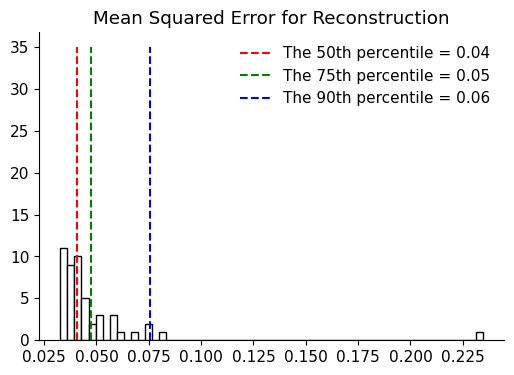

In [15]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.hist(mse_all, bins = 60, edgecolor = 'k', color = 'white')
ax.vlines(np.percentile(np.array(mse_all), 50), ymin = 0, ymax = 35, linestyle = "--", color = 'red', label=f'The 50th percentile = {np.percentile(np.array(mse_all), 50):.2f}')
ax.vlines(np.percentile(np.array(mse_all), 75), ymin = 0, ymax = 35, linestyle = "--", color = 'green', label=f'The 75th percentile = {np.percentile(np.array(mse_all), 75):.2f}')
ax.vlines(np.percentile(np.array(mse_all), 95), ymin = 0, ymax = 35, linestyle = "--", color = 'blue', label=f'The 90th percentile = {np.percentile(np.array(mse_all), 90):.2f}')


ax.set_title('Mean Squared Error for Reconstruction')
ax.spines[['right', 'top']].set_visible(False)
#ax.set_xlim(0, 0.004)
plt.legend(frameon=False)
plt.show()


In [5]:
z = np.zeros((10, 10))
torch.Tensor(z)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [2]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
# Detect ICs on PCB classify them as "normal" or "anomalous"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""




from Utils import *
from CNN_autoencoder import *

def main(confidence = 0.5, threshold = 0.05, img_folder = "../demo-data", 
         weight_path = "../YoloPCB/training_results/PCB_detection_best.pt", 
         yolo_path = "../YoloPCB", model_path = '../models/IC_AE_cpu.pth'):

    """
    Detect IC components on PCB images using YOLOv5 object detection model and CNN autoencoder.

    Args:
    confidence (float): confidence threshold for object detection using YOLOv5 (default: 0.5)
    threshold (float): threshold value for anomaly detection using CNN autoencoder (default: 0.05)
    img_folder (str): folder path containing PCB images to be processed (default: "../demo-data")
    weight_path (str): path to YOLOv5 model weights (default: "../YoloPCB/training_results/PCB_detection_best.pt")
    yolo_path (str): path to YOLOv5 codebase (default: "../YoloPCB")
    model_path (str): path to trained CNN autoencoder model (default: "../models/IC_AE_cpu.pth")
    """
    # Load images that you want to detect
    image_list = [load_image(os.path.join(img_folder, img)) for img in os.listdir(img_folder)]

    # Load CNN autoencoder model for anomaly detetection
    device, CNN_AE = load_cnn_autoencoder(model_path)

    # Load YOLOv5 object detection model
    model = load_model(yolo_path, weight_path, confidence = confidence)
    # Create a dir to save processed images
    try:
        os.mkdir('../processed_images')
    except:
        print('Directory already exists')   
    
    # Loop through each image in the folder
    for idx, (save_name, img_array1) in enumerate(image_list):
        
        # Detect objects using YOLOv5
        results = model(img_array1) # batch of images

        # Convert results to pandas dataframe
        df  = pd.DataFrame(results.pandas().xyxy[0])
        df[['xmin', 'xmax','ymin', 'ymax']] = df[['xmin', 'xmax','ymin', 'ymax']].astype(int)
        df_ic = df[df['name'] ==  'ic']

        # Extract IC components from the image and process them using CNN autoencoder
        try:
            ic_s = [cv2.resize(img_array1[dict(i)['ymin']:dict(i)['ymax'], dict(i)['xmin']:dict(i)['xmax']], (400, 400)) for ixc, i in df_ic.iterrows()]
            
            # Prepare images for CNN detection
            imgs = torch.Tensor((np.array(ic_s)/255).transpose(0, 3, 1, 2)).to(device)
            
            # Calculate error for encoded images.
            mse_all = [(((to_cpu(i) - to_cpu(CNN_AE(i)))**2).mean()) for idx, i in enumerate(imgs)]

            # Plot the original image with detected IC components and anomalies highlighted
            plot_PCBwithDetection(df_ic = df_ic, save_name = save_name, mse_all = mse_all, threshold = threshold, img = img_array1, printimg = True)
            print(imgs.shape)

        except:
            # if no detected IC compoenets print image name and save image
            print(save_name[:-4] + ".jpg")
            cv2.imwrite(os.path.join('../processed_images', save_name[:-4] + ".jpg"), img_array1)

if __name__ == '__main__':
    main()
    #plt.show()

YOLOv5 🚀 2023-4-20 Python-3.10.10 torch-2.0.0 CPU

Fusing layers... 
Model summary: 322 layers, 86193601 parameters, 0 gradients
Adding AutoShape... 


Directory already exists
torch.Size([6, 3, 400, 400])
torch.Size([12, 3, 400, 400])
torch.Size([24, 3, 400, 400])
torch.Size([37, 3, 400, 400])
torch.Size([24, 3, 400, 400])
